# Test current ACCESS-OM2 WOA data interpolation

ACCESS-OM2 initial conditions, mapped from WOA input, is here: `/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc`

ACCESS-OM2 land mask: `/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_mask.nc`

**Goal**: Examine ACCESS-OM2 initial conditions extrapolation southwards into ice shelf cavities, to assess what modifications may be needed for MOM6 pan-An with ice shelves.

GEBCO 2024 ice: `/g/data/ik11/inputs/GEBCO_2024/GEBCO_2024_sub_ice_topo.nc` (this is a big file though)

In [1]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41865,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:34865,Total threads: 2
Dashboard: /proxy/35925/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:43587,


In [3]:
IC_path = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc'
OM2_mask_path = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_mask.nc'

IC = xr.open_dataset(IC_path)
OM2_mask = xr.open_dataset(OM2_mask_path)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


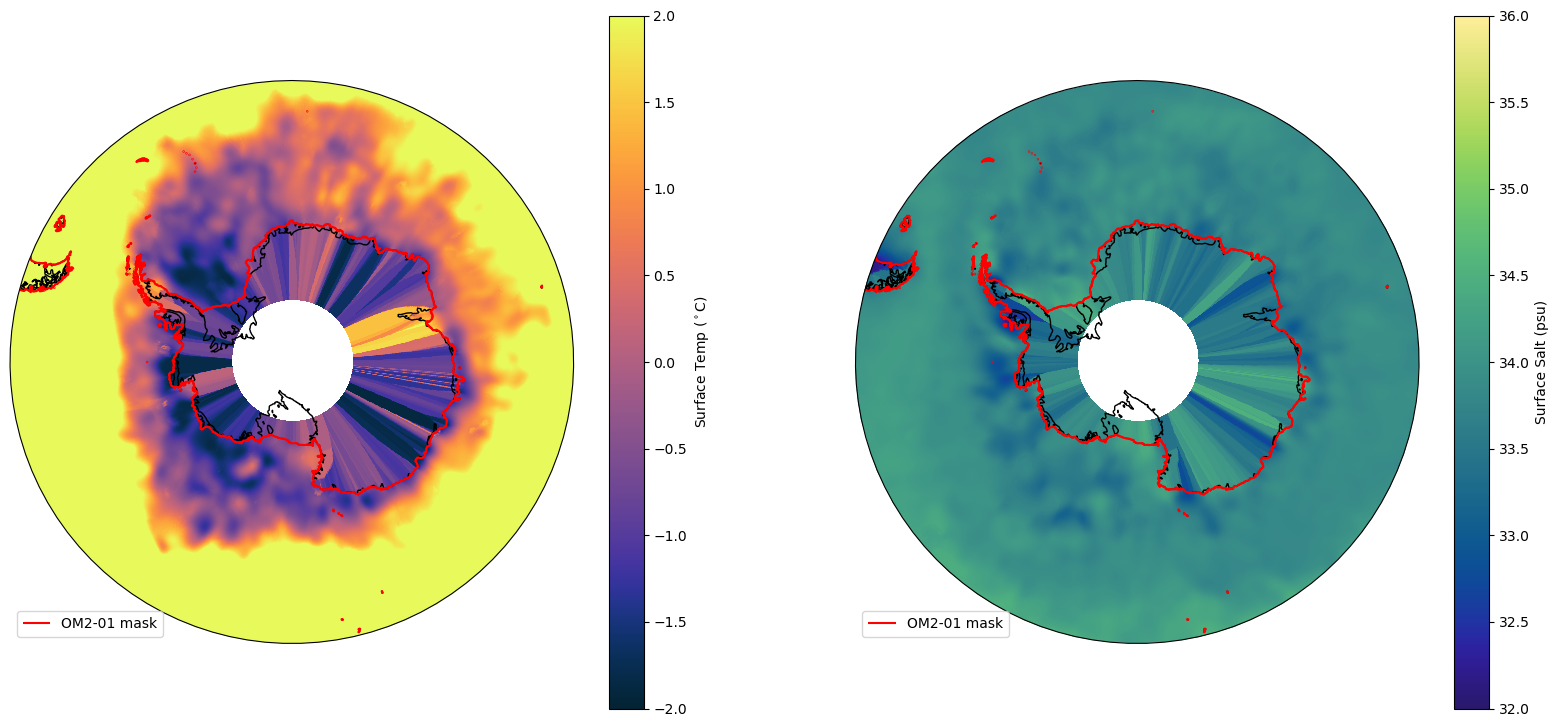

In [9]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(1,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.


theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(IC.GRID_X_T,
               IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
               IC.temp.isel(GRID_Y_T = slice(0,1000),ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = 'Surface Temp ($^\circ$C)')

CS2 = plt.contour(IC.GRID_X_T,
            IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
            OM2_mask.mask.isel(ny = slice(0,1000)),
            transform=ccrs.PlateCarree(), levels = [0.5],colors = 'r')
h1,l1 = CS2.legend_elements()
plt.legend([h1[0]], ['OM2-01 mask'], loc = 'lower left')

ax = fig.add_subplot(1,2,2,projection=projection)

ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
ax.coastlines(resolution="50m")
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(IC.GRID_X_T,
               IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
               IC.salt.isel(GRID_Y_T = slice(0,1000),ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = 32,vmax = 36, cmap = cmo.haline)
plt.colorbar(label = 'Surface Salt (psu)')

CS2 = plt.contour(IC.GRID_X_T,
            IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
            OM2_mask.mask.isel(ny = slice(0,1000)),
            transform=ccrs.PlateCarree(), levels = [0.5],colors = 'r')
h1,l1 = CS2.legend_elements()
plt.legend([h1[0]], ['OM2-01 mask'], loc = 'lower left')


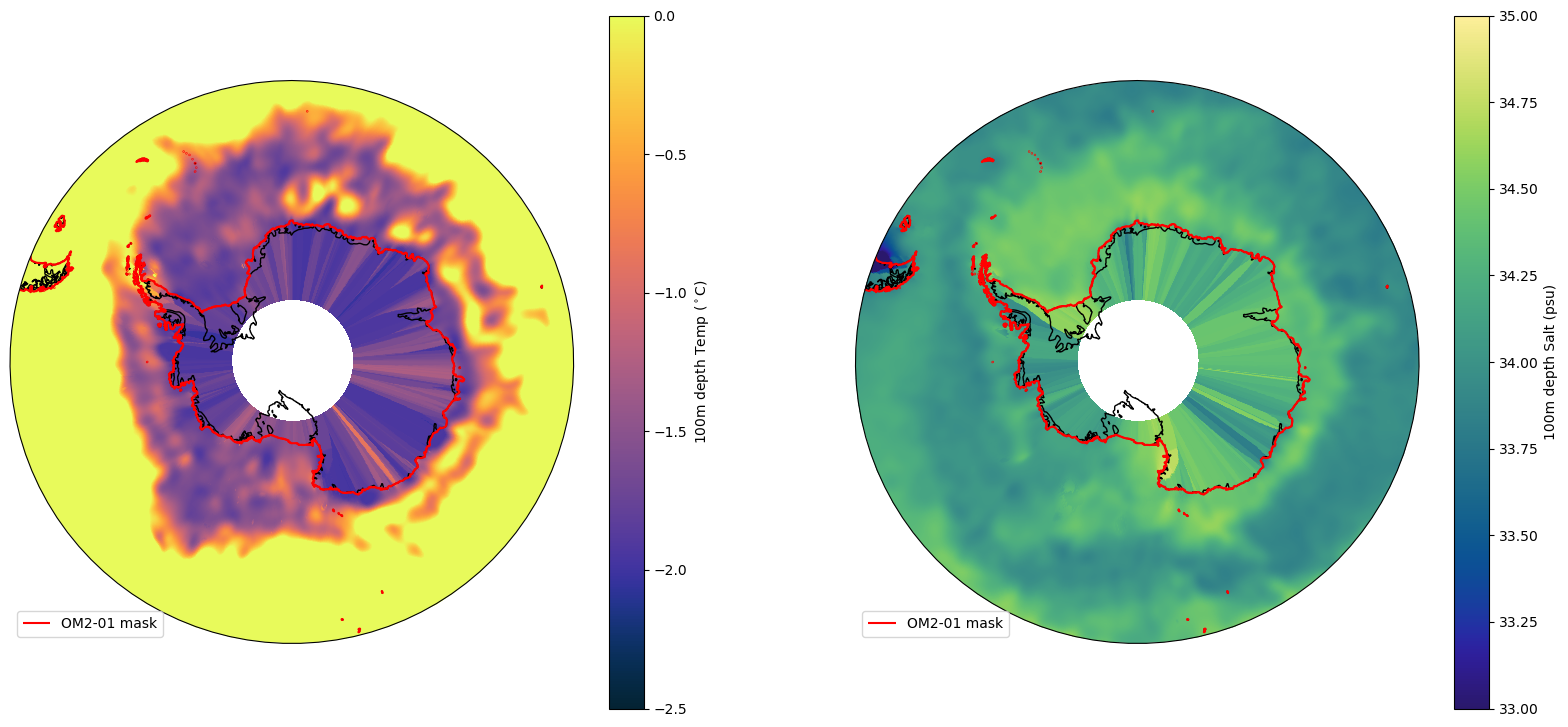

In [11]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(1,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.


theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(IC.GRID_X_T,
               IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
               IC.temp.isel(GRID_Y_T = slice(0,1000),time = 0).sel(ZT = 100, method = 'nearest'),
               transform=ccrs.PlateCarree(), vmin = -2.5, vmax = 0, cmap = cmo.thermal)
plt.colorbar(label = '100m depth Temp ($^\circ$C)')

CS2 = plt.contour(IC.GRID_X_T,
            IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
            OM2_mask.mask.isel(ny = slice(0,1000)),
            transform=ccrs.PlateCarree(), levels = [0.5],colors = 'r')
h1,l1 = CS2.legend_elements()
plt.legend([h1[0]], ['OM2-01 mask'], loc = 'lower left')

ax = fig.add_subplot(1,2,2,projection=projection)

ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
ax.coastlines(resolution="50m")
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(IC.GRID_X_T,
               IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
               IC.salt.isel(GRID_Y_T = slice(0,1000),time = 0).sel(ZT = 100, method = 'nearest'),
               transform=ccrs.PlateCarree(), vmin = 33,vmax = 35, cmap = cmo.haline)
plt.colorbar(label = '100m depth Salt (psu)')

CS2 = plt.contour(IC.GRID_X_T,
            IC.GRID_Y_T.isel(GRID_Y_T = slice(0,1000)),
            OM2_mask.mask.isel(ny = slice(0,1000)),
            transform=ccrs.PlateCarree(), levels = [0.5],colors = 'r')
h1,l1 = CS2.legend_elements()
plt.legend([h1[0]], ['OM2-01 mask'], loc = 'lower left')


### Definitely getting some cross-over between the Amundsen Sea and Filcher-Ronne IS in Weddell Sea, though it isn't warm water that is getting in in this case contrary to our expectation!

Possible solution: different extrapolation code, i.e. not following down straight to South Pole as that causes the cross-over between Amundsen and Weddell

#### To do: Also examine individual smaller ice shelf cavities by zooming in.

#### To do: Use actual ice mask instead of whatever cartopy gives me (black lines = cartopy coastlines)
